In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use('ggplot')
import random
from random import randint
import math

In [204]:
food_amount = 100
pacman_amount = 20
board_size = 1000
default_health = 5
pacmen = []
food = []
crot = 1
cloc = 0
cbite = 1
turn_loss = 0
phi_prec = (80/255.)
alpha_prec = 10/255.
delta_prec = 10/255.
pacman_radius = 1
food_health = 5

In [205]:
class pacman:
    def __init__(self):
        #change dynamically
        self.x = randint(0,board_size)
        self.y = randint(0,board_size)
        self.theta = randint(0,359)
        self.health = default_health
        self.active = 1
        #dna
        self.phi = randint(0,255)
        self.alpha = randint(0,255)
        self.delta = randint(0,255)
        
        self.phi_val = self.phi*phi_prec
        self.alpha_val = self.alpha*alpha_prec
        self.delta_val = self.delta*delta_prec
        #self.f = closest food
        #self.dist = closest food distance
    def __bool__(self):
        return True
    
    def __repr__(self):
        return "{pacman, x:"+str(self.x)+", y:"+str(self.y)+", theta:"+str(self.theta)+"}"
    
    def find_dist(self,f):
        return np.sqrt((self.x-f.x)**2 + (self.y-f.y)**2)
    
    def find_angle(self,f):
        dx = f.x - self.x
        dy = f.y - self.y
        arc = math.degrees(math.atan((dy/dx)))
        theta1 = 1
        if dx > 0:
            if dy > 0:
                theta1 = 180 - arc
            else:
                theta1 = 180 + arc
        else:
            if dy > 0:
                theta1 = arc
            else:
                theta1 = 360 - arc
        if theta1 < 0:
            theta1 = 360 + theta1
        #print(theta1)
        return theta1
    
    def check_angle(self,f):#check if the food is in the range
        left_bound = self.theta - (self.phi_val/2)
        right_bound = self.theta + (self.phi_val/2)
        f_angle = self.find_angle(f)
        if(left_bound < f_angle and right_bound > f_angle):
            return True
        if(left_bound < f_angle + 360. and right_bound > f_angle + 360.):
            return True
        return False
        
    def find_food(self):
        global food
        closest = False
        closest_dist = False
        for i in food:
            dist = self.find_dist(i)
            if((dist < closest_dist or not closest_dist) and (self.check_angle(i))):
                closest = i
                closest_dist = dist
            self.f = closest
            self.dist = closest_dist
        if(closest != False):
            return True
        return False
        
    def rotate_to_food(self):
        #cost of rotate = crot*theta*health
        #no cost to rotation
        new_theta = self.find_angle(self.f)
        error = random.uniform(self.alpha_val/-2., self.alpha_val/2.)
        self.theta = new_theta + error
        
    def get_food(self):
        self.rotate_to_food()
        error = random.uniform(self.delta_val/-2., self.delta_val/2.)
        new_dist = self.dist + error
        angle = self.find_angle(self.f)
        self.x += new_dist*np.cos(angle)
        self.y += new_dist*np.sin(angle)
        cost = cloc*new_dist
        self.health -= cost
        #cost of rotate
    
    def bite(self):
        to_food = self.find_dist(self.f)
        self.health -= cbite
        if(to_food < pacman_radius):#means the bite was sucessful
            self.health += food_health
            self.f.reset()
            
    
    def random_rotate(self):
        self.theta = randint(0,359)
        #self.health += randint(-2,1)
    
    def step(self):
        self.health -= turn_loss
        if(self.find_food()):
            self.get_food()
            self.bite()
        self.random_rotate()
    
    
    def get_genes(self):
        return[self.phi,self.alpha,self.delta]
    
    def set_genes(self,genes):
        self.phi = genes[0]
        self.alpha = genes[1]
        self.delta = genes[2]
        
    def to_bits(self):
        genes = self.get_genes()
        split_genes = []
        for i in genes:
            bin_str = format(i, '#010b')
            bin_str = bin_str[2:]
            split_genes.append([bin_str[:4],bin_str[4:]])
        return split_genes
    
    def reproduce(self,other):
        son1 = pacman()
        son2 = pacman()
        son1_genes = []
        son2_genes = []
        mybits = self.to_bits()
        otherbits = other.to_bits()
        for i,v in enumerate(mybits):
            son1_gene = v[0]+otherbits[i][1]
            son2_gene = otherbits[i][0]+v[1]
            son1_gene = int('0b'+son1_gene,base=2)
            son2_gene = int('0b'+son2_gene,base=2)
            son1_genes.append(son1_gene)
            son2_genes.append(son2_gene)
        son1.set_genes(son1_genes)
        son2.set_genes(son2_genes)
        return [son1,son2]
        
        
p = pacman()
p2 = pacman()
print(p.reproduce(p2))

[{pacman, x:445, y:858, theta:300}, {pacman, x:108, y:770, theta:101}]


In [206]:
class dot:
    def __init__(self):
        self.x = random.uniform(0, board_size)
        self.y = random.uniform(0, board_size)
        self.active = 1
    def __repr__(self):
        return "{dot, x:"+str(self.x)+", y:"+str(self.y)+"}"
    def reset(self):
        self.x = random.uniform(0, board_size)
        self.y = random.uniform(0, board_size)

In [207]:
def gen1():
    global pacmen
    pacmen = []
    for i in range(0,pacman_amount):
        p = pacman()
        pacmen.append(p)
    pacmen = np.array(pacmen)
    print(pacmen[0])
    return pacmen

def food1():
    global food
    food = []
    for i in range(0,food_amount):
        f = dot()
        food.append(f)
    food = np.array(food)
    return food

In [217]:
def driver(gen,life_span,generations):
    food = food1()
    dt = 1
    t = [0]
    tracker = []
    genetics = []
    
    global pacmen
    
    for g in range(0,generations): #iterates through each generation
        tracker.append([])
        genetics.append(pacmen[1].phi)
        for i in pacmen:
            tracker[g].append([])
            
        t.append(t[-1]+dt)
        for q in range(0,life_span): #runs through time with current generation
            for i,v in enumerate(pacmen):
                tracker[g][i].append([v.x,v.y,v.theta])
                v.step()
        
        
        #makes the next generation
        sons = []
        healthy_pacmen = []
        for i,v in enumerate(pacmen): #end of a generation mean reproduce
                if(v.health > 0 or True): #will never kill off
                    healthy_pacmen.append(v)

        for i,v in enumerate(healthy_pacmen):
            if( i % 2 == 1):
                temp = v.reproduce(healthy_pacmen[randint(0,len(healthy_pacmen)-1)])
                sons.extend(temp)
                
        #print('generation over')
        pacmen = sons
        
    return t,tracker,genetics

In [218]:
t,tracker,genetics = driver(gen1(),10,20)

{pacman, x:771, y:154, theta:235}


[32, 96, 0, 16, 0, 176, 32, 96, 160, 96, 160, 96, 96, 96, 160, 160, 0, 0, 160, 160]


<IPython.core.display.Javascript object>


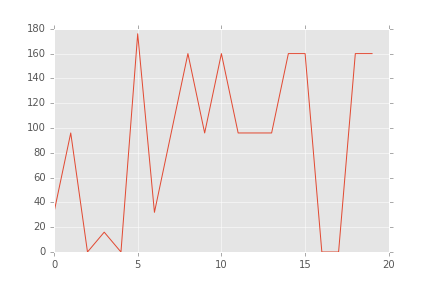

In [219]:
#print(tracker[0])
print(genetics)
plt.figure()
plt.plot(genetics)